# Text Analytics - Group Assignment - Group #1

This notebook provides a sample implementation of different models for Image-to-Text, or Image Captioning, applications.

First, we show an approach based on Convolutional and Recurrent Neural Networks (CNN, RNN, respectively), then we present several Transformers based models for comparison.



## 1. Dataset import from Github

As mentioned, since the aim of this notebook is to provide sample implementations, a limited set of 10 images will be used as input.

All images are located in the "images" folder of the group's public Github Repository, which can be accessed through the following link:
https://github.com/DuongBui24/text_analytics_g1

This section focuses on reading these images so they can be used later.

In [1]:
# import required libraries
from PIL import Image
import requests
from urllib.request import urlopen
import io
import pandas as pd
import numpy as np

In [2]:
# function for reading images from Github Repo
def get_image_from_url(url):
  """
  Downloads an image from the specified URL and returns a PIL Image object.
  Args:
      url (str): URL of the image.
  Returns:
      PIL.Image: Image object or None on error.
  """
  try:
    response = urlopen(url)
    image_data = response.read()
    return Image.open(io.BytesIO(image_data))
  except (IOError, OSError) as e:
    print(f"Error downloading image from {url}: {e}")
    return None

In [3]:
# parameters for image reading, this access a public github repo and creates a list of images

# Github path, this should be updated as needed by the end-user
github_folder_url = "https://raw.githubusercontent.com/DuongBui24/text_analytics_g1/main/images/"

# creates list of image file names, change image_n as needed. files in .jpg
image_n = 9
image_names = []
for i in range(image_n):
  image = 'image'+str(i+1)+'.jpg'
  image_names.append(image)
image_names

images = []
for image_name in image_names:
  image_url = f"{github_folder_url}{image_name}"
  image = get_image_from_url(image_url)
  if image:
    images.append(image)

In [4]:
# image labels
true_captions = pd.read_csv('https://raw.githubusercontent.com/DuongBui24/text_analytics_g1/main/images/captions2.txt', sep = ',')

labels = []
for image in image_names:
  label = true_captions.loc[true_captions['image'] == image].iloc[0]
  labels.append(label[1])

display(labels)

['A person eats takeout while watching a small television .',
 'A cart containig two man be pull by horse in the rain .',
 'A few dog swim in a lake .',
 'A football player in a full stadium jump and recieving a football .',
 'A laugh woman in a scarf .',
 'A horse mascot give high five to some football fan . ',
 'A boy in a red top be hang upside down from a tree .',
 'Two panda on a tree .',
 'Two panda on a tree .']

## 2. CNN - LSTM based approach (using pretrained models)

This section is a demo of how the Image Captioning problem can be tackled by Neural Networks before the introduction of Transformers. This acts as the "before" stage in this "before and after" exercise.

For this process, we'll do image captioning using Convolutional Neural Networks and a type of Recurrent Neural Network (LSTM).

### Set-up environment

In [ ]:
# Import Modules
import os
import pickle
import numpy as np
import glob
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from keras.models import load_model
import requests

In [ ]:
# Check if the text_analytics_g1 directory exists in the current directory
if not os.path.exists('text_analytics_g1'):
    # If it doesn't exist, clone the GitHub repository
    !git clone https://github.com/DuongBui24/text_analytics_g1.git
else:
    # If it exists, change directory to text_analytics_g1 and update it
    %cd text_analytics_g1
    # Check if the directory is empty
    if os.listdir():  # If not empty
        print("Directory is not empty. Pulling updates...")
        # Attempt to pull updates
        !git pull origin main  # Assuming 'main' is the main branch name
    else:
        print("Directory is empty. Cloning repository...")
        %cd ..
        !rm -rf text_analytics_g1
        !git clone https://github.com/DuongBui24/text_analytics_g1.git
        %cd text_analytics_g1

    # Move back to the original directory
    %cd ..

# Set base directory
BASE_DIR = os.path.join(os.getcwd(), 'text_analytics_g1', 'images')

# Set working directory
WORKING_DIR = os.path.join(os.getcwd(), 'text_analytics_g1', 'cnn_ltsm')

# Ensure the working directory exists
os.makedirs(WORKING_DIR, exist_ok=True)


Cloning into 'text_analytics_g1'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 122 (delta 28), reused 92 (delta 17), pack-reused 0
Receiving objects: 100% (122/122), 35.60 MiB | 14.03 MiB/s, done.
Resolving deltas: 100% (28/28), done.


### Convolutional Neural Network for Image Encoding

#### Load pretrained image model

The first step is to encode images, to do so, a pretrained model from Kaggle is used.

Source: https://www.kaggle.com/code/balajikartheek/image-caption-generator-using-cnn-and-lstm


In [ ]:
# Load VGG16 Model (VGG-16 is a convolutional neural network that is 16 layers deep)
model_vgg = VGG16()

# Restructure model
model_vgg = Model(inputs = model_vgg.inputs , outputs = model_vgg.layers[-2].output)

# Summarize
print(model_vgg.summary())

553467096/553467096 [==============================] - 25s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

### Long-Short Term Memory model for Text Generation

Once the image features have been extracted, a LSTM model is used to generate the captions based on these features.

Again, a pretrained model from Kaggle is used.

Source: https://www.kaggle.com/code/balajikartheek/image-caption-generator-using-cnn-and-lstm

#### Load pretrained text model

In [ ]:
# connect to kaggle to download the pretrained model
! pip install -q kaggle

# Check if kaggle.json file exists (API key)
if not os.path.exists("kaggle.json"):
    # Download kaggle.json file
    !wget https://raw.githubusercontent.com/DuongBui24/text_analytics_g1/main/cnn_ltsm/kaggle.json

--2024-05-12 14:53:28--  https://raw.githubusercontent.com/DuongBui24/text_analytics_g1/main/cnn_ltsm/kaggle.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67 [text/plain]
Saving to: ‘kaggle.json’

kaggle.json         100%[===================>]      67  --.-KB/s    in 0s      

2024-05-12 14:53:29 (3.89 MB/s) - ‘kaggle.json’ saved [67/67]



In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle kernels output zohaib123/image-caption-generator-using-cnn-and-lstm -p /content/

Output file downloaded to /content/best_model.h5
Output file downloaded to /content/features.pkl
Output file downloaded to /content/model.png
Kernel log downloaded to /content/image-caption-generator-using-cnn-and-lstm.log 


In [ ]:
!wget https://raw.githubusercontent.com/DuongBui24/text_analytics_g1/main/cnn_ltsm/captions.txt
with open(os.path.join('features.pkl'), 'rb') as f:
    features = pickle.load(f)

with open(os.path.join('captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

# Load the model
best_model = load_model('best_model.h5')
best_model.summary()

--2024-05-12 14:54:23--  https://raw.githubusercontent.com/DuongBui24/text_analytics_g1/main/cnn_ltsm/captions.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3319294 (3.2M) [text/plain]
Saving to: ‘captions.txt’

captions.txt        100%[===================>]   3.17M  --.-KB/s    in 0.02s   

2024-05-12 14:54:24 (203 MB/s) - ‘captions.txt’ saved [3319294/3319294]

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 35)]                 0         []                            
                                                                                  

#### Create mapping of image to caption

In [ ]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

#### Generate captions

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [ ]:
max_length = 35

In [ ]:
# function to get features from new images
def get_features(image):
	# convert image pixels to numpy array
  image = img_to_array(image)
  # reshape data for model
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  # preprocess image for VGG
  image = preprocess_input(image)
  # extract features
  feature = model_vgg.predict(image, verbose=0)
  return feature

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# function to generate a caption for each image
def generate_captions(image_name):
  image_id = image_name.split('.')[0]
  img_path = os.path.join(image_name)
  image = load_img(img_path, target_size=(224, 224))
  feature = get_features(image)
  # predict the caption
  y_pred = predict_caption(best_model, feature, tokenizer, max_length)
  #print(y_pred)
  return y_pred


In [ ]:
# creates list to save the generated captions
cnn_captions = []
url = "https://raw.githubusercontent.com/DuongBui24/text_analytics_g1/main/images/"

for image in image_names:
  image_url = f"{url}{image}"
  opened_image = Image.open(io.BytesIO(urlopen(image_url).read()))
  opened_image.save(image, 'JPEG')
  caption = generate_captions(image)
  cnn_captions.append(caption)

cnn_captions

['startseq of throw the boy costume in in in in in in in in in in in in in in in',
 'startseq climb white air as hats in in in in in in in in in in in in in in in',
 'startseq purple boy running woman while the on red in in in in in in in in in in in in',
 "startseq dresses runs on tikes' dresses runs blue bench in in in in in in in in in in in in",
 'startseq tries tries tries of on boy girl man boy with has the on child in in in in in in',
 'startseq tattoos wrestling in in in in car out in in in in in in in in in in in in',
 'startseq grass to the camera down and while man children jump in the four in in in in in in in',
 'startseq boy with team standing in dog boy with team standing in in in in in in in in in in',
 'startseq boy with team is dogs below in large dogs dog walking with in in in in in in in in']

In [ ]:
# time (captions): 42 seconds
# captions:
# ['startseq of throw the boy costume in in in in in in in in in in in in in in in',
#  'startseq climb white air as hats in in in in in in in in in in in in in in in',
#  'startseq purple boy running woman while the on red in in in in in in in in in in in in',
#  "startseq dresses runs on tikes' dresses runs blue bench in in in in in in in in in in in in",
#  'startseq tries tries tries of on boy girl man boy with has the on child in in in in in in',
#  'startseq tattoos wrestling in in in in car out in in in in in in in in in in in in',
#  'startseq grass to the camera down and while man children jump in the four in in in in in in in',
#  'startseq boy with team standing in dog boy with team standing in in in in in in in in in in',
#  'startseq boy with team is dogs below in large dogs dog walking with in in in in in in in in']

## 3. Transformers based approach

This section is a demo of how Transformers revolutionised the Image Captioning problem, by simplifying processes while returning better outputs at the same time, vs. the CNN-LSTM approach.

### Salesforce BLIP

BLIP: Bootstrapping Language-Image Pre-training for Unified Vision-Language Understanding and Generation.

Model card for image captioning pretrained on COCO dataset - base architecture (with ViT large backbone).

[huggingface.co/Salesforce/blip-image-captioning-large](https://huggingface.co/Salesforce/blip-image-captioning-large)

In [ ]:
# load required libraries, processors and models
from transformers import BlipProcessor, BlipForConditionalGeneration

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

In [ ]:
# get descriptions
blip_captions = []
for image in images:
  inputs = processor(image, return_tensors="pt")
  out = model.generate(**inputs)
  blip_captions.append(processor.decode(out[0], skip_special_tokens=True))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [ ]:
blip_captions

# time (captions): 2 min
# captions:
# ['someone is sitting on the ground watching a television with a cat on it',
#  'horses pulling a carriage with people in it on a rainy day',
#  'dogs playing in a pool of water with a ball in it',
#  'arafed football player catching a ball while another player tries to catch it',
#  'woman holding a black dog in her arms and laughing',
#  'araffe dressed in red and white holding a tennis racket',
#  'araffed girl upside down on a tree branch in a park',
#  'panda bear eating bamboo in zoo enclosure with tree branch in foreground',
#  'pandas eating bamboo in a zoo enclosure with a tree branch']

['someone is sitting on the ground watching a television with a cat on it',
 'horses pulling a carriage with people in it on a rainy day',
 'dogs playing in a pool of water with a ball in it',
 'arafed football player catching a ball while another player tries to catch it',
 'woman holding a black dog in her arms and laughing',
 'araffe dressed in red and white holding a tennis racket',
 'araffed girl upside down on a tree branch in a park',
 'panda bear eating bamboo in zoo enclosure with tree branch in foreground',
 'pandas eating bamboo in a zoo enclosure with a tree branch']

### Salesforce BLIP2
In this notebook, we'll demonstrate the capabilities of the latest BLIP-2 model from Salesforce. It excels in tasks such as image captioning, visual question answering, and general image-related conversations.


In this notebook, we'll highlight the int8 quantization algorithm pioneered by bitsandbytes. This innovative method enables the smooth execution of hefty models on standard hardware configurations, such as those found in Google Colab.

Documentation and usage examples can be found in :
*   [github.com/NielsRogge/Transformers-Tutorials/tree/master/BLIP-2](https://github.com/NielsRogge/Transformers-Tutorials/tree/master/BLIP-2)
*   [huggingface.co/Salesforce/blip2-opt-2.7b](https://huggingface.co/Salesforce/blip2-opt-2.7b)




#### Set-up environment

We'll start by installing Hugging Face Transformers. Note that it's advised to run this notebook on a GPU environment, high RAM.

In [ ]:
!pip install torch torchvision -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 90.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.

In [ ]:
# install required libraries

!pip install accelerate
!pip install transformers
!pip install -i https://pypi.org/simple/ bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 4.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 6.6 MB/s eta 0:00:00


#### Load model and processor

Here, we're loading a BLIP-2 checkpoint that utilizes the pre-trained OPT model by Meta AI, boasting 2.7 billion parameters.

In [ ]:
# load required libraries, processor and model
from transformers import AutoProcessor, Blip2ForConditionalGeneration
from transformers import BitsAndBytesConfig
import torch

quantization_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.bfloat16)
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")

# there are several ways to load the model:
# model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b") # load in float32
# model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16) # load in float16
# model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", device_map="auto", load_in_8bit=True) # load in int8
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", device_map="auto", quantization_config=quantization_config) # load in int8

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.96k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/127k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/5.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Let's use the GPU, as it will make generation a lot faster.

In [ ]:
#import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

#### Image captioning
If you don't provide a text prompt, the model will automatically commence generating text from the BOS (beginning-of-sequence) token. Consequently, it will produce a caption for the image.

In [ ]:
# get descriptions
inputs = []
for image in images:
  input = processor(image, return_tensors="pt").to(device, torch.float16)
  inputs.append(input)

blip2_captions = []
for input in inputs:
  generated_ids = model.generate(**input, max_new_tokens=20)
  generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
  blip2_captions.append(generated_text)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation f

In [ ]:
blip2_captions

# time (caption): 3 minutes
# captions
# ['person sitting on the ground',
#  'a man and his dog',
#  'a group of dogs in a pool',
#  'a man in a yellow and white uniform',
#  'a woman holding a dog',
#  'a man in a red shirt',
#  'a young woman hanging upside down from a tree',
#  'two pandas eating bamboo',
#  'two pandas eating bamboo']

['person sitting on the ground',
 'a man and his dog',
 'a group of dogs in a pool',
 'a man in a yellow and white uniform',
 'a woman holding a dog',
 'a man in a red shirt',
 'a young woman hanging upside down from a tree',
 'two pandas eating bamboo',
 'two pandas eating bamboo']

### NOTE: Running BLIP2 with CPU

Due to session limits, this implementation uses the GPU version of the model. However, there is an alternate version available that runs on CPU. The caveat is that more than 15 GB of RAM are needed, given the size of the model itself.

The commented code below provides an example on how to implement the CPU version, assuming RAM requirements are met.

In [ ]:
# # BLIP2 on CPU
# # import libraries
# import requests
# from PIL import Image
# from transformers import Blip2Processor, Blip2ForConditionalGeneration

# # download processor and model
# processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
# model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b")

# # provide instruction
# question = "Caption the image"

# # get descriptions
# inputs = []
# for image in images:
#   input = processor(image, question, return_tensors="pt")
#   inputs.append(input)

# blip2_captions = []
# for input in inputs:
#   generated_ids = model.generate(**input)
#   generated_text = processor.decode(generated_ids[0], skip_special_tokens=True).strip()
#   blip2_captions.append(generated_text)

### Microsoft GIT based coco

> The model applies Microsoft GIT (Generative Image-to-text Transformer) fine tuned on the Coco (Common Objects in Context) dataset which containinf over 330,000 images across 80 object categories.

Documentation and usage examples can be found in: https://huggingface.co/microsoft/git-base-coco





In [ ]:
from transformers import (
    AutoProcessor,
    AutoModelForCausalLM)

In [ ]:
# load processor and model
processor = AutoProcessor.from_pretrained("microsoft/git-base-coco")
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base-coco")

preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/707M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

In [ ]:
# get descriptions
pixel_values = []
for image in images:
  pixel_v = processor(images=image, return_tensors="pt").pixel_values
  pixel_values.append(pixel_v)

gitcoco_captions = []
for pixel_v in pixel_values:
  generated_id = model.generate(pixel_values=pixel_v, max_length=50)
  generated_caption = processor.batch_decode(generated_id, skip_special_tokens=True)
  gitcoco_captions.append(generated_caption[0])

In [ ]:
gitcoco_captions

# time (captions): 1 minutes
# captions:
# ['a person sitting on the ground watching tv',
#  'a couple of horses pulling a cart in the rain.',
#  'a group of dogs swimming in a pond.',
#  'american football player catches a touchdown pass over american football player.',
#  'a woman with a dog in her mouth.',
#  'mascot greets fans at a game.',
#  'a boy in a tree',
#  'pandas playing with a branch',
#  'two pandas are playing with a branch.']

['a person sitting on the ground watching tv',
 'a couple of horses pulling a cart in the rain.',
 'a group of dogs swimming in a pond.',
 'american football player catches a touchdown pass over american football player.',
 'a woman with a dog in her mouth.',
 'mascot greets fans at a game.',
 'a boy in a tree',
 'pandas playing with a branch',
 'two pandas are playing with a branch.']

### Moondream2

The "Moondream2" model is a Multimodal Model (Image-to-text and Text-to-text) trained on 1.86 billion parameters that uses a Transformers architechture.

It uses SigLIP (Sigmoid loss for Language-Image Pre-training) and Microsoft's Phi-1.5 as Language Model. The first acts as an encoder for the image, while the latter is the NLP decoder.

Documentation and usage examples can be found in:
* https://huggingface.co/vikhyatk/moondream2
* https://github.com/vikhyat/moondream




In [ ]:
# installation of libraries (only install the first time runnign this notebook)
!pip install transformers einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.7 MB/s eta 0:00:00


In [ ]:
# load requiered libraries
from transformers import AutoModelForCausalLM, AutoTokenizer

In [ ]:
# load model version
model_id = "vikhyatk/moondream2"
revision = "2024-04-02"
model = AutoModelForCausalLM.from_pretrained(
    model_id, trust_remote_code=True, revision=revision
)
tokenizer = AutoTokenizer.from_pretrained(model_id, revision=revision)

config.json:   0%|          | 0.00/318 [00:00<?, ?B/s]

configuration_moondream.py:   0%|          | 0.00/3.39k [00:00<?, ?B/s]

moondream.py:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

vision_encoder.py:   0%|          | 0.00/4.94k [00:00<?, ?B/s]

modeling_phi.py:   0%|          | 0.00/49.4k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.72G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# encode images
encoded_images = []
for image in images:
  enc_image = model.encode_image(image)
  encoded_images.append(enc_image)

In [ ]:
# get descriptions
moondream2_captions = []
for image in encoded_images:
  desc = model.answer_question(image, "Caption the image in less than 20 words.", tokenizer)
  moondream2_captions.append(desc)

In [ ]:
moondream2_captions

# time (captions): 13 minutes (2 minutes encoding + 11 minutes descriptions)
# captions:
# ['A person is sitting on the ground with a television in front of them.',
#  'A horse pulling a carriage with two horses and a man in a red hat.',
#  'A group of dogs playing in a pool with a yellow stick in their mouths.',
#  'A football player in a jersey with the number 36 is jumping to catch a football.',
#  'A woman with a dog in her arms and a shirt that says Stop Bitching Stars.',
#  'A man in a red shirt with the number 1 on it is shaking hands with a mascot.',
#  'A person hanging upside down from a tree in a park.',
#  'Two panda bears are playing with a tree branch.',
#  'Two panda bears are playing with a tree branch.']

['A person is sitting on the ground with a television in front of them.',
 'A horse pulling a carriage with two horses and a man in a red hat.',
 'A group of dogs playing in a pool with a yellow stick in their mouths.',
 'A football player in a jersey with the number 36 is jumping to catch a football.',
 'A woman with a dog in her arms and a shirt that says Stop Bitching Stars.',
 'A man in a red shirt with the number 1 on it is shaking hands with a mascot.',
 'A person hanging upside down from a tree in a park.',
 'Two panda bears are playing with a tree branch.',
 'Two panda bears are playing with a tree branch.']

## 4. Consolidated Results

**IMPORTANT**!!! DO NOT run this chunk if all models have run without issues in the nokebook. Running this chunk with override all captions generated by each model. Only run this chunk if GPU or RAM memory limit is reached thus the notebook must be split to run across Colab accounts.

In [ ]:
cnn_captions = ['startseq of throw the boy costume in in in in in in in in in in in in in in in',
 'startseq climb white air as hats in in in in in in in in in in in in in in in',
 'startseq purple boy running woman while the on red in in in in in in in in in in in in',
 "startseq dresses runs on tikes' dresses runs blue bench in in in in in in in in in in in in",
 'startseq tries tries tries of on boy girl man boy with has the on child in in in in in in',
 'startseq tattoos wrestling in in in in car out in in in in in in in in in in in in',
 'startseq grass to the camera down and while man children jump in the four in in in in in in in',
 'startseq boy with team standing in dog boy with team standing in in in in in in in in in in',
 'startseq boy with team is dogs below in large dogs dog walking with in in in in in in in in']

blip_captions = ['someone is sitting on the ground watching a television with a cat on it',
 'horses pulling a carriage with people in it on a rainy day',
 'dogs playing in a pool of water with a ball in it',
 'arafed football player catching a ball while another player tries to catch it',
 'woman holding a black dog in her arms and laughing',
 'araffe dressed in red and white holding a tennis racket',
 'araffed girl upside down on a tree branch in a park',
 'panda bear eating bamboo in zoo enclosure with tree branch in foreground',
 'pandas eating bamboo in a zoo enclosure with a tree branch']

blip2_captions = ['person sitting on the ground',
 'a man and his dog',
 'a group of dogs in a pool',
 'a man in a yellow and white uniform',
 'a woman holding a dog',
 'a man in a red shirt',
 'a young woman hanging upside down from a tree',
 'two pandas eating bamboo',
 'two pandas eating bamboo']

gitcoco_captions = ['a person sitting on the ground watching tv',
 'a couple of horses pulling a cart in the rain.',
 'a group of dogs swimming in a pond.',
 'american football player catches a touchdown pass over american football player.',
 'a woman with a dog in her mouth.',
 'mascot greets fans at a game.',
 'a boy in a tree',
 'pandas playing with a branch',
 'two pandas are playing with a branch.']

moondream2_captions = ['A person is sitting on the ground with a television in front of them.',
 'A horse pulling a carriage with two horses and a man in a red hat.',
 'A group of dogs playing in a pool with a yellow stick in their mouths.',
 'A football player in a jersey with the number 36 is jumping to catch a football.',
 'A woman with a dog in her arms and a shirt that says Stop Bitching Stars.',
 'A man in a red shirt with the number 1 on it is shaking hands with a mascot.',
 'A person hanging upside down from a tree in a park.',
 'Two panda bears are playing with a tree branch.',
 'Two panda bears are playing with a tree branch.']

Results from all previous models are consolidated in a single dataframe for easier comparison.


In [ ]:
# concatenate image names with all image captions, one column for each model, into a single dataframe
data_full = pd.concat([pd.Series(image_names), pd.Series(labels), pd.Series(cnn_captions), pd.Series(blip_captions), pd.Series(blip2_captions), pd.Series(gitcoco_captions), pd.Series(moondream2_captions)], axis=1)
data_full = data_full.rename(columns={0: 'image', 1:'label', 2:'CNN_LSTM', 3:'BLIP', 4:'BLIP2', 5:'git_coco', 6:'moondream2'})
data_full.head()

,image,label,CNN_LSTM,BLIP,BLIP2,git_coco,moondream2
0,image1.jpg,A person eats takeout while watching a small t...,startseq of throw the boy costume in in in in ...,someone is sitting on the ground watching a te...,person sitting on the ground,a person sitting on the ground watching tv,A person is sitting on the ground with a telev...
1,image2.jpg,A cart containig two man be pull by horse in t...,startseq climb white air as hats in in in in i...,horses pulling a carriage with people in it on...,a man and his dog,a couple of horses pulling a cart in the rain.,A horse pulling a carriage with two horses and...
2,image3.jpg,A few dog swim in a lake .,startseq purple boy running woman while the on...,dogs playing in a pool of water with a ball in it,a group of dogs in a pool,a group of dogs swimming in a pond.,A group of dogs playing in a pool with a yello...
3,image4.jpg,A football player in a full stadium jump and r...,startseq dresses runs on tikes' dresses runs b...,arafed football player catching a ball while a...,a man in a yellow and white uniform,american football player catches a touchdown p...,A football player in a jersey with the number ...
4,image5.jpg,A laugh woman in a scarf .,startseq tries tries tries of on boy girl man ...,woman holding a black dog in her arms and laug...,a woman holding a dog,a woman with a dog in her mouth.,A woman with a dog in her arms and a shirt tha...


In [ ]:
# save consolidated results as csv file for later use
data_full.to_csv('consolidated_captions.csv')

## 5. Integrated Image to Speech solution

Image to Text can be integrated with Text to Speech to form an integrated Image to Speech solution for vision dispaired audiences. Given the scope of this project focusing on various Image capturing models, the following Text to Speech technique (adopting Bark, a transformer-based text-to-audio model created by Suno https://huggingface.co/suno/bark-small) is presented for illustration of a complete application.



In [ ]:
from transformers import pipeline

pipe = pipeline("text-to-speech", model="suno/bark-small")

config.json:   0%|          | 0.00/8.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
/usr/local/lib/python3.10/dist-packages/transformers/models/encodec/modeling_encodec.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("padding_total", torch.tensor(kernel_size - stride, dtype=torch.int64), persistent=False)


generation_config.json:   0%|          | 0.00/4.91k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/353 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
text = str(moondream2_captions[0])
output = pipe(text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:10000 for open-end generation.


In [ ]:
from IPython.display import Audio
Audio(output["audio"], rate=output["sampling_rate"])

## 6. Evaluation

### Install libraries

In [ ]:
pip install rouge

In [ ]:
from nltk.stem import WordNetLemmatizer
from gensim.parsing.preprocessing import remove_stopwords
import string
string.punctuation
import nltk
nltk.download('wordnet')
nltk.download('punkt')
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
from nltk import word_tokenize

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Create functions to calculate scores and lemmatize captions

In [ ]:
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree

In [ ]:
#defining the object for Lemmatization
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatizer(text):
    lemm_text = wordnet_lemmatizer.lemmatize(text)
    return lemm_text

In [ ]:
def calculate_bleu_score(generated_summary, reference_summary):
    # Tokenize the generated and reference summaries
    gen_summary_tokens = nltk.word_tokenize(generated_summary.lower())
    ref_summary_tokens = [nltk.word_tokenize(reference_summary.lower())]

    # Calculate BLEU score
    bleu_score = sentence_bleu(ref_summary_tokens, gen_summary_tokens)

    return np.round(bleu_score * 100,2)

In [ ]:
def calculate_rouge_score(generated_summary, reference_summary):
    rouge = Rouge()
    rouge_scores = rouge.get_scores(generated_summary, reference_summary)
    #print(rouge_scores)
    rouge_score = rouge_scores[0]['rouge-l']['f']
    return np.round(rouge_score * 100,2)

In [ ]:
df = data_full

In [ ]:
df

,image,label,CNN_LSTM,BLIP,BLIP2,git_coco,moondream2
0,image1.jpg,A person eats takeout while watching a small t...,startseq of throw the boy costume in in in in ...,someone is sitting on the ground watching a te...,person sitting on the ground,a person sitting on the ground watching tv,A person is sitting on the ground with a telev...
1,image2.jpg,A cart containig two man be pull by horse in t...,startseq climb white air as hats in in in in i...,horses pulling a carriage with people in it on...,a man and his dog,a couple of horses pulling a cart in the rain.,A horse pulling a carriage with two horses and...
2,image3.jpg,A few dog swim in a lake .,startseq purple boy running woman while the on...,dogs playing in a pool of water with a ball in it,a group of dogs in a pool,a group of dogs swimming in a pond.,A group of dogs playing in a pool with a yello...
3,image4.jpg,A football player in a full stadium jump and r...,startseq dresses runs on tikes' dresses runs b...,arafed football player catching a ball while a...,a man in a yellow and white uniform,american football player catches a touchdown p...,A football player in a jersey with the number ...
4,image5.jpg,A laugh woman in a scarf .,startseq tries tries tries of on boy girl man ...,woman holding a black dog in her arms and laug...,a woman holding a dog,a woman with a dog in her mouth.,A woman with a dog in her arms and a shirt tha...
5,image6.jpg,A horse mascot give high five to some football...,startseq tattoos wrestling in in in in car out...,araffe dressed in red and white holding a tenn...,a man in a red shirt,mascot greets fans at a game.,A man in a red shirt with the number 1 on it i...
6,image7.jpg,A boy in a red top be hang upside down from a ...,startseq grass to the camera down and while ma...,araffed girl upside down on a tree branch in a...,a young woman hanging upside down from a tree,a boy in a tree,A person hanging upside down from a tree in a ...
7,image8.jpg,Two panda on a tree .,startseq boy with team standing in dog boy wit...,panda bear eating bamboo in zoo enclosure with...,two pandas eating bamboo,pandas playing with a branch,Two panda bears are playing with a tree branch.
8,image9.jpg,Two panda on a tree .,startseq boy with team is dogs below in large ...,pandas eating bamboo in a zoo enclosure with a...,two pandas eating bamboo,two pandas are playing with a branch.,Two panda bears are playing with a tree branch.


### Obtain scores

In [ ]:
# Define reference summary and generated summary
reference_summary_df = df['label']
generated_summary_CNN_df = df['CNN_LSTM']
generated_summary_BLIP_df = df['BLIP']
generated_summary_BLIP2_df = df['BLIP2']
generated_summary_COCO_df = df['git_coco']
generated_summary_MOONDREAM_df = df['moondream2']


In [ ]:
bleu_score_list_CNN = []
bleu_score_list_BLIP = []
bleu_score_list_BLIP2 = []
bleu_score_list_COCO = []
bleu_score_list_MOONDREAM = []

rogue_score_list_CNN = []
rogue_score_list_BLIP = []
rogue_score_list_BLIP2 = []
rogue_score_list_COCO = []
rogue_score_list_MOONDREAM = []

In [ ]:
# Calculate Rouge score
for i in range(len(df)):
  generated_summary_text_CNN = lemmatizer(remove_punctuation(remove_stopwords(generated_summary_CNN_df[i])).lower())
  generated_summary_text_BLIP = lemmatizer(remove_punctuation(remove_stopwords(generated_summary_BLIP_df[i])).lower())
  generated_summary_text_BLIP2 = lemmatizer(remove_punctuation(remove_stopwords(generated_summary_BLIP2_df[i])).lower())
  generated_summary_text_COCO = lemmatizer(remove_punctuation(remove_stopwords(generated_summary_COCO_df[i])).lower())
  generated_summary_text_MOONDREAM = lemmatizer(remove_punctuation(remove_stopwords(generated_summary_MOONDREAM_df[i])).lower())

  reference_summary_text = lemmatizer(remove_punctuation(remove_stopwords(reference_summary_df[i])).lower())

  rogue_score_list_CNN.append(calculate_rouge_score(generated_summary_text_CNN,
                                                     reference_summary_text))
  rogue_score_list_BLIP.append(calculate_rouge_score(generated_summary_text_BLIP,
                                                     reference_summary_text))
  rogue_score_list_BLIP2.append(calculate_rouge_score(generated_summary_text_BLIP2,
                                                     reference_summary_text))
  rogue_score_list_COCO.append(calculate_rouge_score(generated_summary_text_COCO,
                                                     reference_summary_text))
  rogue_score_list_MOONDREAM.append(calculate_rouge_score(generated_summary_text_MOONDREAM,
                                                     reference_summary_text))

In [ ]:
len(df)

9

In [ ]:
 # Calculate BLEU score
for i in range(len(df)):
  bleu_score_list_CNN.append(calculate_bleu_score(generated_summary_CNN_df[i],reference_summary_df[i]))
  bleu_score_list_BLIP.append(calculate_bleu_score(generated_summary_BLIP_df[i],reference_summary_df[i]))
  bleu_score_list_BLIP2.append(calculate_bleu_score(generated_summary_BLIP2_df[i],reference_summary_df[i]))
  bleu_score_list_COCO.append(calculate_bleu_score(generated_summary_COCO_df[i],reference_summary_df[i]))
  bleu_score_list_MOONDREAM.append(calculate_bleu_score(generated_summary_MOONDREAM_df[i],reference_summary_df[i]))

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

### Merge scores with the results dataframe

In [ ]:
df['bleu_score_CNN'] = pd.Series(bleu_score_list_CNN)
df['bleu_score_BLIP'] = pd.Series(bleu_score_list_BLIP)
df['bleu_score_BLIP2'] = pd.Series(bleu_score_list_BLIP2)
df['bleu_score_COCO'] = pd.Series(bleu_score_list_COCO)
df['bleu_score_MOONDREAM'] = pd.Series(bleu_score_list_MOONDREAM)

df['rouge_score_CNN'] = pd.Series(rogue_score_list_CNN)
df['rouge_score_BLIP'] = pd.Series(rogue_score_list_BLIP)
df['rouge_score_BLIP2'] = pd.Series(rogue_score_list_BLIP2)
df['rouge_score_COCO'] = pd.Series(rogue_score_list_COCO)
df['rouge_score_MOONDREAM'] = pd.Series(rogue_score_list_MOONDREAM)
print(df.shape)
df

(9, 17)


,image,label,CNN_LSTM,BLIP,BLIP2,git_coco,moondream2,bleu_score_CNN,bleu_score_BLIP,bleu_score_BLIP2,bleu_score_COCO,bleu_score_MOONDREAM,rouge_score_CNN,rouge_score_BLIP,rouge_score_BLIP2,rouge_score_COCO,rouge_score_MOONDREAM
0,image1.jpg,A person eats takeout while watching a small t...,startseq of throw the boy costume in in in in ...,someone is sitting on the ground watching a te...,person sitting on the ground,a person sitting on the ground watching tv,A person is sitting on the ground with a telev...,0.0,0.0,0.0,0.00,0.00,0.0,33.33,20.00,33.33,46.15
1,image2.jpg,A cart containig two man be pull by horse in t...,startseq climb white air as hats in in in in i...,horses pulling a carriage with people in it on...,a man and his dog,a couple of horses pulling a cart in the rain.,A horse pulling a carriage with two horses and...,0.0,0.0,0.0,23.26,0.00,0.0,0.00,22.22,33.33,26.67
2,image3.jpg,A few dog swim in a lake .,startseq purple boy running woman while the on...,dogs playing in a pool of water with a ball in it,a group of dogs in a pool,a group of dogs swimming in a pond.,A group of dogs playing in a pool with a yello...,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,16.67
3,image4.jpg,A football player in a full stadium jump and r...,startseq dresses runs on tikes' dresses runs b...,arafed football player catching a ball while a...,a man in a yellow and white uniform,american football player catches a touchdown p...,A football player in a jersey with the number ...,0.0,0.0,0.0,0.00,28.63,0.0,30.77,0.00,33.33,42.86
4,image5.jpg,A laugh woman in a scarf .,startseq tries tries tries of on boy girl man ...,woman holding a black dog in her arms and laug...,a woman holding a dog,a woman with a dog in her mouth.,A woman with a dog in her arms and a shirt tha...,0.0,0.0,0.0,0.00,0.00,0.0,20.00,28.57,28.57,30.77
5,image6.jpg,A horse mascot give high five to some football...,startseq tattoos wrestling in in in in car out...,araffe dressed in red and white holding a tenn...,a man in a red shirt,mascot greets fans at a game.,A man in a red shirt with the number 1 on it i...,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,20.00,26.67
6,image7.jpg,A boy in a red top be hang upside down from a ...,startseq grass to the camera down and while ma...,araffed girl upside down on a tree branch in a...,a young woman hanging upside down from a tree,a boy in a tree,A person hanging upside down from a tree in a ...,0.0,0.0,26.8,12.56,32.87,0.0,33.33,36.36,50.00,50.00
7,image8.jpg,Two panda on a tree .,startseq boy with team standing in dog boy wit...,panda bear eating bamboo in zoo enclosure with...,two pandas eating bamboo,pandas playing with a branch,Two panda bears are playing with a tree branch.,0.0,0.0,0.0,0.00,0.00,0.0,33.33,0.00,0.00,66.67
8,image9.jpg,Two panda on a tree .,startseq boy with team is dogs below in large ...,pandas eating bamboo in a zoo enclosure with a...,two pandas eating bamboo,two pandas are playing with a branch.,Two panda bears are playing with a tree branch.,0.0,0.0,0.0,0.00,0.00,0.0,20.00,0.00,0.00,66.67


In [ ]:
# add columns with model name and score that gives the best result
cols_to_find_max = ['bleu_score_CNN', 'rouge_score_CNN',
                    'bleu_score_BLIP', 'rouge_score_BLIP',
                    'bleu_score_BLIP2', 'rouge_score_BLIP2',
                    'bleu_score_COCO', 'rouge_score_COCO',
                    'bleu_score_MOONDREAM', 'rouge_score_MOONDREAM']

In [ ]:
mxs = df.eq(df[cols_to_find_max].max(axis=1), axis=0)
# join the column names of the max values of each row into a single string
df['Maximum_Score_Model'] = mxs.dot(mxs.columns + ', ').str.rstrip(', ')
df['Maximum_Score'] = df[cols_to_find_max].max(axis=1)
df.head()

,image,label,CNN_LSTM,BLIP,BLIP2,git_coco,moondream2,bleu_score_CNN,bleu_score_BLIP,bleu_score_BLIP2,bleu_score_COCO,bleu_score_MOONDREAM,rouge_score_CNN,rouge_score_BLIP,rouge_score_BLIP2,rouge_score_COCO,rouge_score_MOONDREAM,Maximum_Score_Model,Maximum_Score
0,image1.jpg,A person eats takeout while watching a small t...,startseq of throw the boy costume in in in in ...,someone is sitting on the ground watching a te...,person sitting on the ground,a person sitting on the ground watching tv,A person is sitting on the ground with a telev...,0.0,0.0,0.0,0.00,0.00,0.0,33.33,20.00,33.33,46.15,rouge_score_MOONDREAM,46.15
1,image2.jpg,A cart containig two man be pull by horse in t...,startseq climb white air as hats in in in in i...,horses pulling a carriage with people in it on...,a man and his dog,a couple of horses pulling a cart in the rain.,A horse pulling a carriage with two horses and...,0.0,0.0,0.0,23.26,0.00,0.0,0.00,22.22,33.33,26.67,rouge_score_COCO,33.33
2,image3.jpg,A few dog swim in a lake .,startseq purple boy running woman while the on...,dogs playing in a pool of water with a ball in it,a group of dogs in a pool,a group of dogs swimming in a pond.,A group of dogs playing in a pool with a yello...,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,16.67,rouge_score_MOONDREAM,16.67
3,image4.jpg,A football player in a full stadium jump and r...,startseq dresses runs on tikes' dresses runs b...,arafed football player catching a ball while a...,a man in a yellow and white uniform,american football player catches a touchdown p...,A football player in a jersey with the number ...,0.0,0.0,0.0,0.00,28.63,0.0,30.77,0.00,33.33,42.86,rouge_score_MOONDREAM,42.86
4,image5.jpg,A laugh woman in a scarf .,startseq tries tries tries of on boy girl man ...,woman holding a black dog in her arms and laug...,a woman holding a dog,a woman with a dog in her mouth.,A woman with a dog in her arms and a shirt tha...,0.0,0.0,0.0,0.00,0.00,0.0,20.00,28.57,28.57,30.77,rouge_score_MOONDREAM,30.77


In [ ]:
# export evaluation results to pdf
df.to_csv("Models_Evaluation_IMAGE_TO_TEXT.csv", index=False)

### Visualize Scores

#### Data wrangling
The first step is to transform the results dataframe into a friendlier format, then, two subplots are presented where all stress-test scenarios are visualised.

In [ ]:
# transform results dataframe into long format for easier manipulation
df_long = pd.concat([df[['image']], df.iloc[:, 7:-2]], axis=1)
df_long = pd.concat([df_long, pd.Series(['Darkness', 'Rainy', 'Multiobjects', 'Motion', 'Facial Emotion', 'Fooling Image', 'Rotation', 'Adversarial', 'Adversarial'])], axis=1)
df_long = df_long.rename(columns={0:'scenario'})
df_long = pd.wide_to_long(df_long, stubnames = ['bleu_score', 'rouge_score'], i = ['image', 'scenario'] , j = 'model', sep = '_', suffix = '\w+')
df_long = df_long.rename(columns={'bleu_score':'BLEU', 'rouge_score':'ROUGE'})
df_long = df_long.reset_index()
df_long = df_long.melt(id_vars = ['image', 'scenario', 'model'], value_vars = ['BLEU', 'ROUGE'], var_name = 'score_name', value_name = 'score')
df_long.head(20)

,image,scenario,model,score_name,score
0,image1.jpg,Darkness,CNN,BLEU,0.00
1,image1.jpg,Darkness,BLIP,BLEU,0.00
2,image1.jpg,Darkness,BLIP2,BLEU,0.00
3,image1.jpg,Darkness,COCO,BLEU,0.00
4,image1.jpg,Darkness,MOONDREAM,BLEU,0.00
5,image2.jpg,Rainy,CNN,BLEU,0.00
6,image2.jpg,Rainy,BLIP,BLEU,0.00
7,image2.jpg,Rainy,BLIP2,BLEU,0.00
8,image2.jpg,Rainy,COCO,BLEU,23.26
9,image2.jpg,Rainy,MOONDREAM,BLEU,0.00


#### Plot scores for each scenario

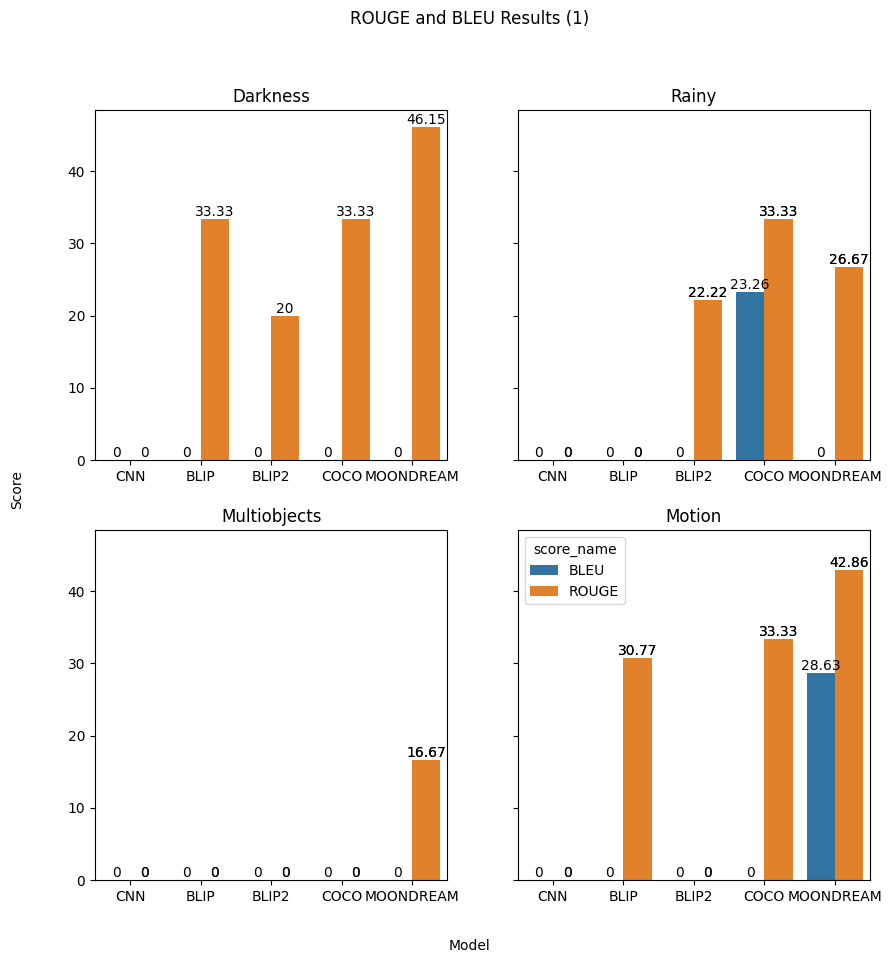

In [ ]:
# import required libraries
import seaborn as sns

# create subplot for the figures
fig.clf()
fig, ax = plt.subplots(2,2, sharey = True, figsize=(10, 10))
fig.suptitle('ROUGE and BLEU Results (1)')
fig.text(0.5, 0.04, 'Model', ha='center')
fig.text(0.04, 0.5, 'Score', va='center', rotation='vertical')

# plot scenarios (1)
ax[0,0].set_title('Darkness')
darkness = sns.barplot(ax=ax[0,0], data=df_long[df_long['scenario'] == 'Darkness'], x='model', y='score', hue='score_name', legend = False)
ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('')
for container in ax[0,0].containers:
    ax[0,0].bar_label(container)

ax[0,1].set_title('Rainy')
sns.barplot(ax=ax[0,1], data=df_long[df_long['scenario'] == 'Rainy'], x='model', y='score', hue='score_name', legend = False)
ax[0,1].set_xlabel('')
ax[0,1].set_ylabel('')
ax[0,1].bar_label(ax[0,1].containers[1])
for container in ax[0,1].containers:
    ax[0,1].bar_label(container)

ax[1,0].set_title('Multiobjects')
sns.barplot(ax=ax[1,0], data=df_long[df_long['scenario'] == 'Multiobjects'], x='model', y='score', hue='score_name', legend = False)
ax[1,0].set_xlabel('')
ax[1,0].set_ylabel('')
ax[1,0].bar_label(ax[1,0].containers[1])
for container in ax[1,0].containers:
    ax[1,0].bar_label(container)

ax[1,1].set_title('Motion')
sns.barplot(ax=ax[1,1], data=df_long[df_long['scenario'] == 'Motion'], x='model', y='score', hue='score_name', legend = True)
ax[1,1].set_xlabel('')
ax[1,1].set_ylabel('')
ax[1,1].bar_label(ax[1,1].containers[1])
for container in ax[1,1].containers:
    ax[1,1].bar_label(container)

# display results
plt.savefig('results1.png')
plt.show()

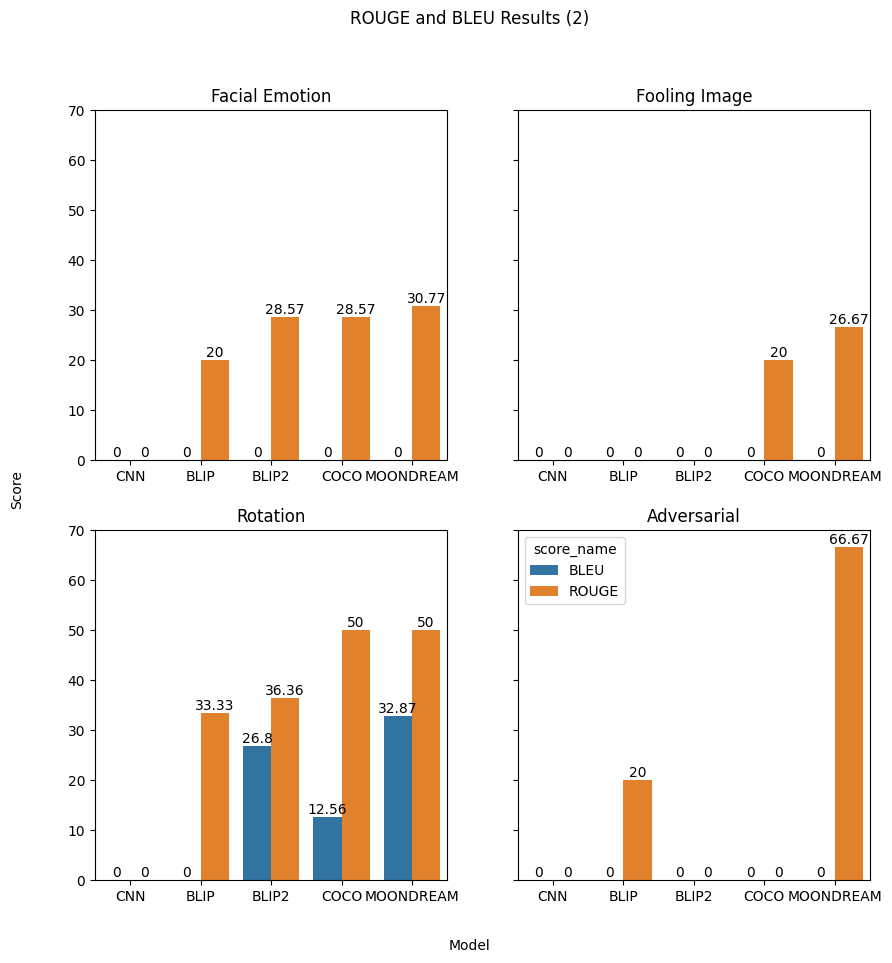

In [ ]:
# create subplot for the figures
fig.clf()
fig2, ax2 = plt.subplots(2,2, sharey = True, figsize=(10, 10))
fig2.suptitle('ROUGE and BLEU Results (2)')
fig2.text(0.5, 0.04, 'Model', ha='center')
fig2.text(0.04, 0.5, 'Score', va='center', rotation='vertical')

# plot scenarios (2)
ax2[0,0].set_title('Facial Emotion')
sns.barplot(ax=ax2[0,0], data=df_long[df_long['scenario'] == 'Facial Emotion'], x='model', y='score', hue='score_name', legend = False)
ax2[0,0].set_xlabel('')
ax2[0,0].set_ylabel('')
for container in ax2[0,0].containers:
    ax2[0,0].bar_label(container)

ax2[0,1].set_title('Fooling Image')
sns.barplot(ax=ax2[0,1], data=df_long[df_long['scenario'] == 'Fooling Image'], x='model', y='score', hue='score_name', legend = False)
ax2[0,1].set_xlabel('')
ax2[0,1].set_ylabel('')
for container in ax2[0,1].containers:
    ax2[0,1].bar_label(container)

ax2[1,0].set_title('Rotation')
sns.barplot(ax=ax2[1,0], data=df_long[df_long['scenario'] == 'Rotation'], x='model', y='score', hue='score_name', legend = False)
ax2[1,0].set_xlabel('')
ax2[1,0].set_ylabel('')
for container in ax2[1,0].containers:
    ax2[1,0].bar_label(container)

ax2[1,1].set_title('Adversarial')
sns.barplot(ax=ax2[1,1], data=df_long[(df_long['scenario'] == 'Adversarial') & (df_long['image'] == 'image9.jpg')], x='model', y='score', hue='score_name', legend = True, errorbar=None)
ax2[1,1].set_xlabel('')
ax2[1,1].set_ylabel('')
for container in ax2[1,1].containers:
    ax2[1,1].bar_label(container)

# display results
plt.savefig('results2.png')
plt.show()

## Appendix: CNN-LSTM based approach (by training the image and text models)

This section provides an alternate approach to CNN-LSTM Image Captioning, by implementing both models (CNN and LSTM) from scratch. This means from defining the models layers to training and testing.

This approach takes longer implementation times than by using a pretrained model, so an example of the process is shown with a sample of 10 images instead of using an entire dataset.

### Load images from Github

In [5]:
# Import Modules
import os
import pickle
import numpy as np
import glob
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input # extract features from image data.
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input , Dense , LSTM , Embedding , Dropout , add

In [13]:
# Check if the text_analytics_g1 directory exists in the current directory
if not os.path.exists('text_analytics_g1'):
    # If it doesn't exist, clone the GitHub repository
    !git clone https://github.com/DuongBui24/text_analytics_g1.git
else:
    # If it exists, change directory to text_analytics_g1 and update it
    %cd text_analytics_g1
    # Check if the directory is empty
    if os.listdir():  # If not empty
        print("Directory is not empty. Pulling updates...")
        # Attempt to pull updates
        !git pull origin main  # Assuming 'main' is the main branch name
    else:
        print("Directory is empty. Cloning repository...")
        %cd ..
        !rm -rf text_analytics_g1
        !git clone https://github.com/DuongBui24/text_analytics_g1.git
        %cd text_analytics_g1

    # Move back to the original directory
    %cd ..

# Set base directory
BASE_DIR = os.path.join(os.getcwd(), 'text_analytics_g1', 'images')

# Set working directory
WORKING_DIR = os.path.join(os.getcwd(), 'text_analytics_g1', 'cnn_ltsm')  # Assuming 'cnn_lstm' is desired, not 'cnn-lstm'

# Ensure the working directory exists
os.makedirs(WORKING_DIR, exist_ok=True)


/content/text_analytics_g1
Directory is not empty. Pulling updates...
From https://github.com/DuongBui24/text_analytics_g1
 * branch            main       -> FETCH_HEAD
Already up to date.
/content


### Feature Extraction for Images

#### Load pretrained model for CNN

In [6]:
# Load VGG16 Model (VGG-16 is a convolutional neural network that is 16 layers deep)
model = VGG16()

# Restructure model
model = Model(inputs = model.inputs , outputs = model.layers[-2].output)

# Summarize
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### Extract image features

In [14]:
features = {}

# Set directory to BASE_DIR
directory = BASE_DIR

if not os.path.exists(directory):
    print("Error: Directory does not exist.")
    exit()

# Get all .jpeg files in BASE_DIR
jpeg_files = glob.glob(os.path.join(directory, '*.jpg'))

for img_path in tqdm(jpeg_files):
    try:
        # load the image from file
        image = load_img(img_path, target_size=(224, 224))
        # convert image pixels to numpy array
        image = img_to_array(image)
        # reshape data for model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # preprocess image for VGG
        image = preprocess_input(image)
        # extract features
        feature = model.predict(image, verbose=0)
        # get image ID
        image_id = os.path.splitext(os.path.basename(img_path))[0]
        # store feature
        features[image_id] = feature
    except Exception as e:
        print(f"Error processing image {img_path}: {str(e)}")


  0%|          | 0/9 [00:00<?, ?it/s]

In [15]:
# store features in pickle and load it from pickles for quicker runtime
# Define the directory where you want to save the pickle file
working_dir = WORKING_DIR

# Define the path for the pickle file
pickle_file_path = os.path.join(working_dir, 'features.pkl')

# Store features in pickle
pickle.dump(features, open(pickle_file_path, 'wb'))

# Check if the pickle file exists
if os.path.exists(pickle_file_path):
    # Load features from pickle
    with open(pickle_file_path, 'rb') as f:
        features = pickle.load(f)
else:
    print("Error: The pickle file does not exist.")

#### Load labels for each image

After loading the labels, a pair is formed with an image id and its caption.

In [16]:
# Load the caption data
file_path = os.path.join(BASE_DIR, 'captions2.txt')

try:
    with open(file_path, 'r') as f:
        next(f)  # Skip the first line if needed
        captions_doc = f.read()
except FileNotFoundError:
    print(f"Error: File '{file_path}' not found.")


In [17]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/9 [00:00<?, ?it/s]

In [18]:
# Check number of images loaded
len(mapping)

9

### Model creation for Text Generation

#### Text preprocessing for captions
Removes stopwords and adds markers for start and end of sequence.

In [19]:
# Data Preprocessing
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [20]:
# before preprocess of text
mapping['image1']

['A person eats takeout while watching a small television .']

In [21]:
# preprocess the text
clean(mapping)

# after preprocess of text
mapping['image1']

['startseq person eats takeout while watching small television endseq']

In [22]:
# Store the preprocessed captions into a list
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

len(all_captions)

9

In [23]:
all_captions[:10]

['startseq person eats takeout while watching small television endseq',
 'startseq cart containig two man be pull by horse in the rain endseq',
 'startseq few dog swim in lake endseq',
 'startseq football player in full stadium jump and recieving football endseq',
 'startseq laugh woman in scarf endseq',
 'startseq horse mascot give high five to some football fan endseq',
 'startseq boy in red top be hang upside down from tree endseq',
 'startseq two panda on tree endseq',
 'startseq two panda on tree endseq']

#### Tokenize captions for text generation model

In [24]:
# Processing the Text Data

# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

52

In [25]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

13

#### Train/Test Split

In [26]:
# Train-Test Split
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [27]:
# Define a batch and include the padding sequence
# Create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

#### Model definition

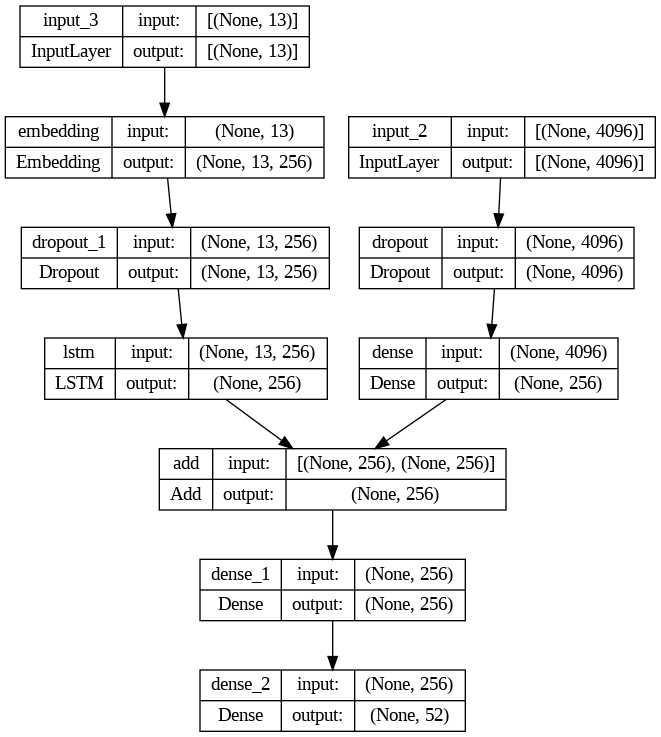

In [28]:
# Model Creation
# Encoder model
# Image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

#### Train the text model

In [29]:
# Train the model
epochs = 50
batch_size = 2
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

4/4 [==============================] - 0s 60ms/step - loss: 0.6054


#### Save the model

In [30]:
# save the model
model.save(WORKING_DIR+'/trained_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Apply CNN/LSTM for Image Captioning

In [31]:
from keras.models import load_model

# Path to the saved model
model_path = WORKING_DIR + '/trained_model.h5'

# Load the model
loaded_model = load_model(model_path)

In [32]:
# Convert the predicted index from the model into a word
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [33]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [34]:
# Model Validation using BLEU Score
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/1 [00:00<?, ?it/s]

BLEU-1: 0.714286
BLEU-2: 0.597614


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [35]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "image1.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print(y_pred)

In [36]:
def list_image_files(directory, extension='.jpg'):
    image_files = []
    for file in os.listdir(directory):
        if file.endswith(extension):
            image_files.append(os.path.join(directory, file))
    return image_files

# Directory containing the images
image_directory = "/content/text_analytics_g1/images"

# List all image files in the directory
image_files = list_image_files(image_directory)
#image_name = os.path.basename(image_files)
image_name = image_names

In [37]:
# cnn_captions = []

# for image in image_names:
#   caption = generate_caption(image)
#   cnn_captions.append(caption)

# print(cnn_captions)

captions = []
# Loop through each image file
for image_file in image_files:
  image_name = os.path.basename(image_file)
  caption = generate_caption(image_name)
  captions.append((image_name, y_pred))

startseq person person takeout while watching small television endseq
startseq containig containig man man be pull by horse in the the rain rain
startseq football player player in stadium jump and recieving football endseq
startseq dog dog swim in lake endseq
startseq horse mascot give high five to some football fan endseq
startseq boy in red top be hang upside down from endseq
startseq laugh woman in scarf endseq
startseq two panda on tree endseq
startseq two two on tree tree endseq
